In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas

In [3]:
od.download('https://www.kaggle.com/datasets/grassknoted/asl-alphabet')

Skipping, found downloaded files in "./asl-alphabet" (use force=True to force download)


In [4]:
import torch
from torch import nn
from pathlib import Path

In [5]:
data_path = Path("asl-alphabet")
image_path = data_path

In [6]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'asl-alphabet'.
There are 1 directories and 0 images in 'asl-alphabet/asl_alphabet_train'.
There are 29 directories and 0 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/E'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/H'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/I'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/M'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/S'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/Y'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/J'.
There are 0 directories and 3000 images in 'asl-alphabet/asl_alphabet_train/asl_a

In [8]:
train_dir = image_path/'asl_alphabet_train'/'asl_alphabet_train'
test_dir = image_path/'asl_alphabet_test'
train_dir, test_dir

(PosixPath('asl-alphabet/asl_alphabet_train/asl_alphabet_train'),
 PosixPath('asl-alphabet/asl_alphabet_test'))

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

In [12]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 87000
    Root location: asl-alphabet/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
val_dataset = datasets.ImageFolder(train_dir, transform=test_transform)

In [14]:
train_dataset.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [15]:
torch.manual_seed(9)
num_train_samples = len(train_dataset)
split = int(num_train_samples*0.25)
indices = torch.randperm(num_train_samples)
train_dataset = torch.utils.data.Subset(train_dataset,indices[split:])
val_dataset = torch.utils.data.Subset(val_dataset,indices[:split])
len(train_dataset),len(val_dataset)

(65250, 21750)

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,batch_size=64,shuffle=True,num_workers=2
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,batch_size=64,shuffle=False,num_workers=2
)

In [17]:
classes = train_dataloader.dataset.dataset.classes
len(classes)

29

Ground truth del


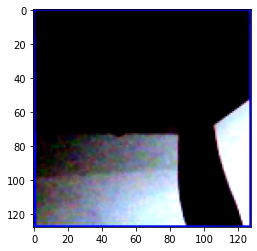

In [18]:
import matplotlib.pyplot as plt
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
import torchvision
from torchvision import models, transforms, datasets

In [21]:

model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
#Recreate the classifier layer
torch.manual_seed(42)
output_shape = len(classes)
model.classifier = torch.nn.Sequential(
torch.nn.Dropout(p=0.2, inplace=True),
torch.nn.Linear(in_features=1280,
               out_features=output_shape,
               bias=True)).to(device)

In [24]:
model # output classes has changed to 29

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [25]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [26]:
from time import time
from tqdm import tqdm

num_epochs = 8
def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)
                    print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                    print(f'Took {time() - iter_time:.3f} seconds')
                    iter_time = time()

                    train_losses.append(running_loss / total_train)
                    val_losses.append(val_loss / total_val)
                print(f'Epoch took {time() - start_time}') 
                torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
    return model, train_losses, val_losses






In [27]:
print_every = 100
num_epoch = 6

model, train_losses, val_losses = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1]/[6]. Batch [100]/[1020]. Train loss 2.370. Train acc 47.234. Val loss 1.516. Val acc 70.993. Took 54.421 seconds
Epoch took 54.421767473220825
Epoch [1]/[6]. Batch [200]/[1020]. Train loss 1.777. Train acc 62.445. Val loss 0.972. Val acc 81.324. Took 43.824 seconds
Epoch took 98.24546837806702
Epoch [1]/[6]. Batch [300]/[1020]. Train loss 1.469. Train acc 69.354. Val loss 0.732. Val acc 86.092. Took 45.033 seconds
Epoch took 143.27835845947266
Epoch [1]/[6]. Batch [400]/[1020]. Train loss 1.266. Train acc 73.828. Val loss 0.600. Val acc 88.377. Took 43.675 seconds
Epoch took 186.95318818092346
Epoch [1]/[6]. Batch [500]/[1020]. Train loss 1.124. Train acc 76.888. Val loss 0.512. Val acc 89.871. Took 44.036 seconds
Epoch took 230.98911237716675
Epoch [1]/[6]. Batch [600]/[1020]. Train loss 1.016. Train acc 79.169. Val loss 0.451. Val acc 90.763. Took 42.935 seconds
Epoch took 273.92431569099426
Epoch [1]/[6]. Batch [700]/[1020]. Train loss 0.936. Train acc 80.786. Val loss 0.4

 17%|█▋        | 1/6 [07:30<37:30, 450.17s/it]

Epoch [2]/[6]. Batch [80]/[1020]. Train loss 0.043. Train acc 84.668. Val loss 0.300. Val acc 93.457. Took 42.129 seconds
Epoch took 42.12867760658264
Epoch [2]/[6]. Batch [180]/[1020]. Train loss 0.062. Train acc 89.983. Val loss 0.275. Val acc 94.179. Took 43.453 seconds
Epoch took 85.58313179016113
Epoch [2]/[6]. Batch [280]/[1020]. Train loss 0.078. Train acc 91.423. Val loss 0.260. Val acc 94.460. Took 44.249 seconds
Epoch took 129.83208751678467
Epoch [2]/[6]. Batch [380]/[1020]. Train loss 0.091. Train acc 92.303. Val loss 0.247. Val acc 94.644. Took 43.079 seconds
Epoch took 172.91108393669128
Epoch [2]/[6]. Batch [480]/[1020]. Train loss 0.101. Train acc 92.819. Val loss 0.235. Val acc 94.772. Took 43.160 seconds
Epoch took 216.07235431671143
Epoch [2]/[6]. Batch [580]/[1020]. Train loss 0.109. Train acc 93.252. Val loss 0.225. Val acc 94.993. Took 43.372 seconds
Epoch took 259.44433784484863
Epoch [2]/[6]. Batch [680]/[1020]. Train loss 0.116. Train acc 93.527. Val loss 0.213

 33%|███▎      | 2/6 [14:46<29:28, 442.13s/it]

Epoch [3]/[6]. Batch [60]/[1020]. Train loss 0.013. Train acc 85.964. Val loss 0.199. Val acc 95.379. Took 40.231 seconds
Epoch took 40.23129200935364
Epoch [3]/[6]. Batch [160]/[1020]. Train loss 0.021. Train acc 92.383. Val loss 0.186. Val acc 95.812. Took 43.443 seconds
Epoch took 83.67416882514954
Epoch [3]/[6]. Batch [260]/[1020]. Train loss 0.027. Train acc 94.069. Val loss 0.179. Val acc 96.023. Took 44.029 seconds
Epoch took 127.70293045043945
Epoch [3]/[6]. Batch [360]/[1020]. Train loss 0.033. Train acc 94.661. Val loss 0.175. Val acc 95.968. Took 44.114 seconds
Epoch took 171.81744647026062
Epoch [3]/[6]. Batch [460]/[1020]. Train loss 0.038. Train acc 95.082. Val loss 0.168. Val acc 96.221. Took 42.982 seconds
Epoch took 214.79926252365112
Epoch [3]/[6]. Batch [560]/[1020]. Train loss 0.043. Train acc 95.366. Val loss 0.163. Val acc 96.267. Took 43.830 seconds
Epoch took 258.6289646625519
Epoch [3]/[6]. Batch [660]/[1020]. Train loss 0.047. Train acc 95.549. Val loss 0.159.

 50%|█████     | 3/6 [22:04<22:00, 440.25s/it]

Epoch [4]/[6]. Batch [40]/[1020]. Train loss 0.006. Train acc 86.562. Val loss 0.152. Val acc 96.193. Took 38.642 seconds
Epoch took 38.64171123504639
Epoch [4]/[6]. Batch [140]/[1020]. Train loss 0.009. Train acc 94.330. Val loss 0.144. Val acc 96.359. Took 44.357 seconds
Epoch took 82.99889492988586
Epoch [4]/[6]. Batch [240]/[1020]. Train loss 0.013. Train acc 95.625. Val loss 0.140. Val acc 96.487. Took 43.473 seconds
Epoch took 126.47239923477173
Epoch [4]/[6]. Batch [340]/[1020]. Train loss 0.016. Train acc 96.057. Val loss 0.138. Val acc 96.533. Took 44.062 seconds
Epoch took 170.53460478782654
Epoch [4]/[6]. Batch [440]/[1020]. Train loss 0.019. Train acc 96.388. Val loss 0.132. Val acc 96.731. Took 43.859 seconds
Epoch took 214.39368891716003
Epoch [4]/[6]. Batch [540]/[1020]. Train loss 0.022. Train acc 96.554. Val loss 0.129. Val acc 96.887. Took 43.598 seconds
Epoch took 257.99221754074097
Epoch [4]/[6]. Batch [640]/[1020]. Train loss 0.025. Train acc 96.697. Val loss 0.130

 67%|██████▋   | 4/6 [29:24<14:39, 439.89s/it]

Epoch [5]/[6]. Batch [20]/[1020]. Train loss 0.002. Train acc 87.422. Val loss 0.121. Val acc 96.920. Took 35.361 seconds
Epoch took 35.3614182472229
Epoch [5]/[6]. Batch [120]/[1020]. Train loss 0.004. Train acc 96.185. Val loss 0.116. Val acc 97.034. Took 43.248 seconds
Epoch took 78.60943055152893
Epoch [5]/[6]. Batch [220]/[1020]. Train loss 0.007. Train acc 96.946. Val loss 0.115. Val acc 97.044. Took 43.569 seconds
Epoch took 122.1781816482544
Epoch [5]/[6]. Batch [320]/[1020]. Train loss 0.009. Train acc 97.271. Val loss 0.114. Val acc 97.007. Took 42.968 seconds
Epoch took 165.1462857723236
Epoch [5]/[6]. Batch [420]/[1020]. Train loss 0.011. Train acc 97.437. Val loss 0.111. Val acc 97.094. Took 42.854 seconds
Epoch took 208.00020480155945
Epoch [5]/[6]. Batch [520]/[1020]. Train loss 0.013. Train acc 97.485. Val loss 0.109. Val acc 97.264. Took 42.711 seconds
Epoch took 250.71134543418884
Epoch [5]/[6]. Batch [620]/[1020]. Train loss 0.014. Train acc 97.535. Val loss 0.108. V

 83%|████████▎ | 5/6 [37:11<07:29, 449.81s/it]

Val loss 0.102. Val acc 97.274. Took 42.757 seconds
Epoch took 467.2701258659363
Epoch [6]/[6]. Batch [100]/[1020]. Train loss 0.008. Train acc 87.250. Val loss 0.115. Val acc 96.657. Took 44.095 seconds
Epoch took 44.09520983695984
Epoch [6]/[6]. Batch [200]/[1020]. Train loss 0.009. Train acc 92.711. Val loss 0.103. Val acc 97.182. Took 43.299 seconds
Epoch took 87.39463067054749
Epoch [6]/[6]. Batch [300]/[1020]. Train loss 0.011. Train acc 94.469. Val loss 0.099. Val acc 97.260. Took 42.897 seconds
Epoch took 130.29296398162842
Epoch [6]/[6]. Batch [400]/[1020]. Train loss 0.012. Train acc 95.422. Val loss 0.098. Val acc 97.343. Took 42.636 seconds
Epoch took 172.9299259185791
Epoch [6]/[6]. Batch [500]/[1020]. Train loss 0.013. Train acc 95.963. Val loss 0.097. Val acc 97.416. Took 43.245 seconds
Epoch took 216.1746940612793
Epoch [6]/[6]. Batch [600]/[1020]. Train loss 0.014. Train acc 96.357. Val loss 0.095. Val acc 97.467. Took 43.557 seconds
Epoch took 259.73135447502136
Epoch

100%|██████████| 6/6 [44:24<00:00, 444.13s/it]


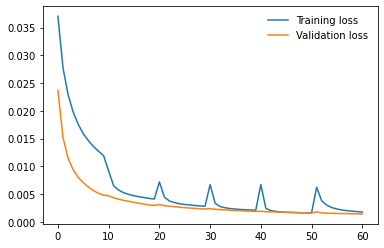

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()